In [1]:
import sys
sys.path.append('modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import matplotlib
import figures as fg
import general as gn
from itertools import repeat
import math
import matplotlib as mpl

%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scipy
from collections import defaultdict
import matplotlib.patheffects as pe
import logomaker
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
data = pd.read_pickle('data/averaged_chec_sumprom.gz')
gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)

sagie_dat2= pd.read_csv('data/external_datasets/tfs_sumprom.csv')
sagie_dat2.index=gp.index

newdat = pd.read_pickle('data/sumprom_20230328_last_one.gz')
med15newdat = newdat.filter(regex='Med15')
med15newdat.columns = [name[:-2] for name in med15newdat.columns.values]
med15newdat = med15newdat.transpose().reset_index().groupby('index').mean().transpose()
med15newdat.columns.name = None
med15newdat.columns = [name.split('_')[-1].capitalize().replace('gal4ad', 'Gal4AD').replace('gcn4ad', 'Gcn4AD')+'_med15mnase' for name in med15newdat.columns.values]

opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan


data_waro = data
data_waro = data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})

nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')


data_waro = data_waro.loc[bins.drop('MNASE').index]
sagie_dat2 = sagie_dat2.loc[bins.drop('MNASE').index]
opn = opn.loc[bins.drop('MNASE').index]
med15newdat = med15newdat.loc[bins.index[:-1]]
gal11_lab_dat = med15newdat.Native_med15mnase

In [4]:
conc_ts = lambda x: pd.Index(np.concatenate(np.concatenate(x.values))).drop_duplicates(keep='first')
def mark_edges(ax):
    
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    return None

In [6]:

fig6df = pd.read_csv('data/fig6df.csv', index_col=0)
targets_fig6df = fg.get_targets_df(fig6df ,3,'df', opn, '')
top10 = targets_fig6df.applymap(lambda x: x[:10])

In [7]:
scores = defaultdict(dict)
for col in fig6df.columns:
    for name, targets in top10.to_dict()['df'].items():
        scores[col][name] = fig6df.loc[targets, col].sum()

comp_data = defaultdict(dict)
for col in fig6df.columns:
    for name, targets in top10.to_dict()['df'].items():
        comp_data[col][name] = fig6df.loc[targets, col].values


In [8]:
xla = ['Med15', 'Gal4F', 'Gal4DBDGal11', 'Yap1F', 'Yap1DBDGal11', 'Gcn4F', 'Gcn4DBDGal11', 'Mig3F', 'Mig3DBDGal11', 'Rpn4F', 'Rpn4DBDGal11']
promsig_data = pd.DataFrame(comp_data).filter(regex="Native|Gal11", axis=1).filter(regex="Native|Full_d|Gal11", axis=0).stack().reset_index()
promsig_data.columns = ['Sig', 'Targets', 'Proms']
targ_sig = pd.DataFrame(comp_data).transpose().filter(regex='Native|DBDGal11').filter(regex='Full_d', axis=0)


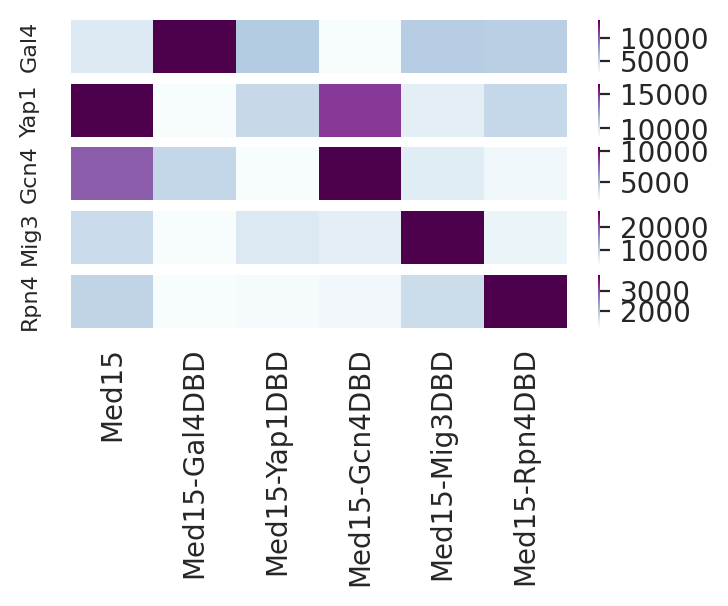

In [10]:
keys = targ_sig.transpose().to_dict().keys()
ylabs = ['Gal4', 'Yap1', 'Gcn4', 'Mig3', 'Rpn4']
fig, ax = plt.subplots(len(keys), 1, sharex=True, sharey=False, figsize=(4,2))
ax = ax.flatten()
for keyi, axi, yi in zip(keys, ax, ylabs) :
    sns.heatmap(pd.DataFrame(pd.DataFrame(targ_sig.transpose().to_dict()[keyi]).mean()).transpose(), ax=axi, cmap='BuPu', annot= False)
    axi.set_ylabel(yi, size=8)
    axi.set_yticklabels('')
axi.set_xticklabels(['Med15'] + list(('Med15-'+pd.Index(ylabs)+'DBD')))
fig.show()

fig.savefig('figures/Supp/S14B.pdf')

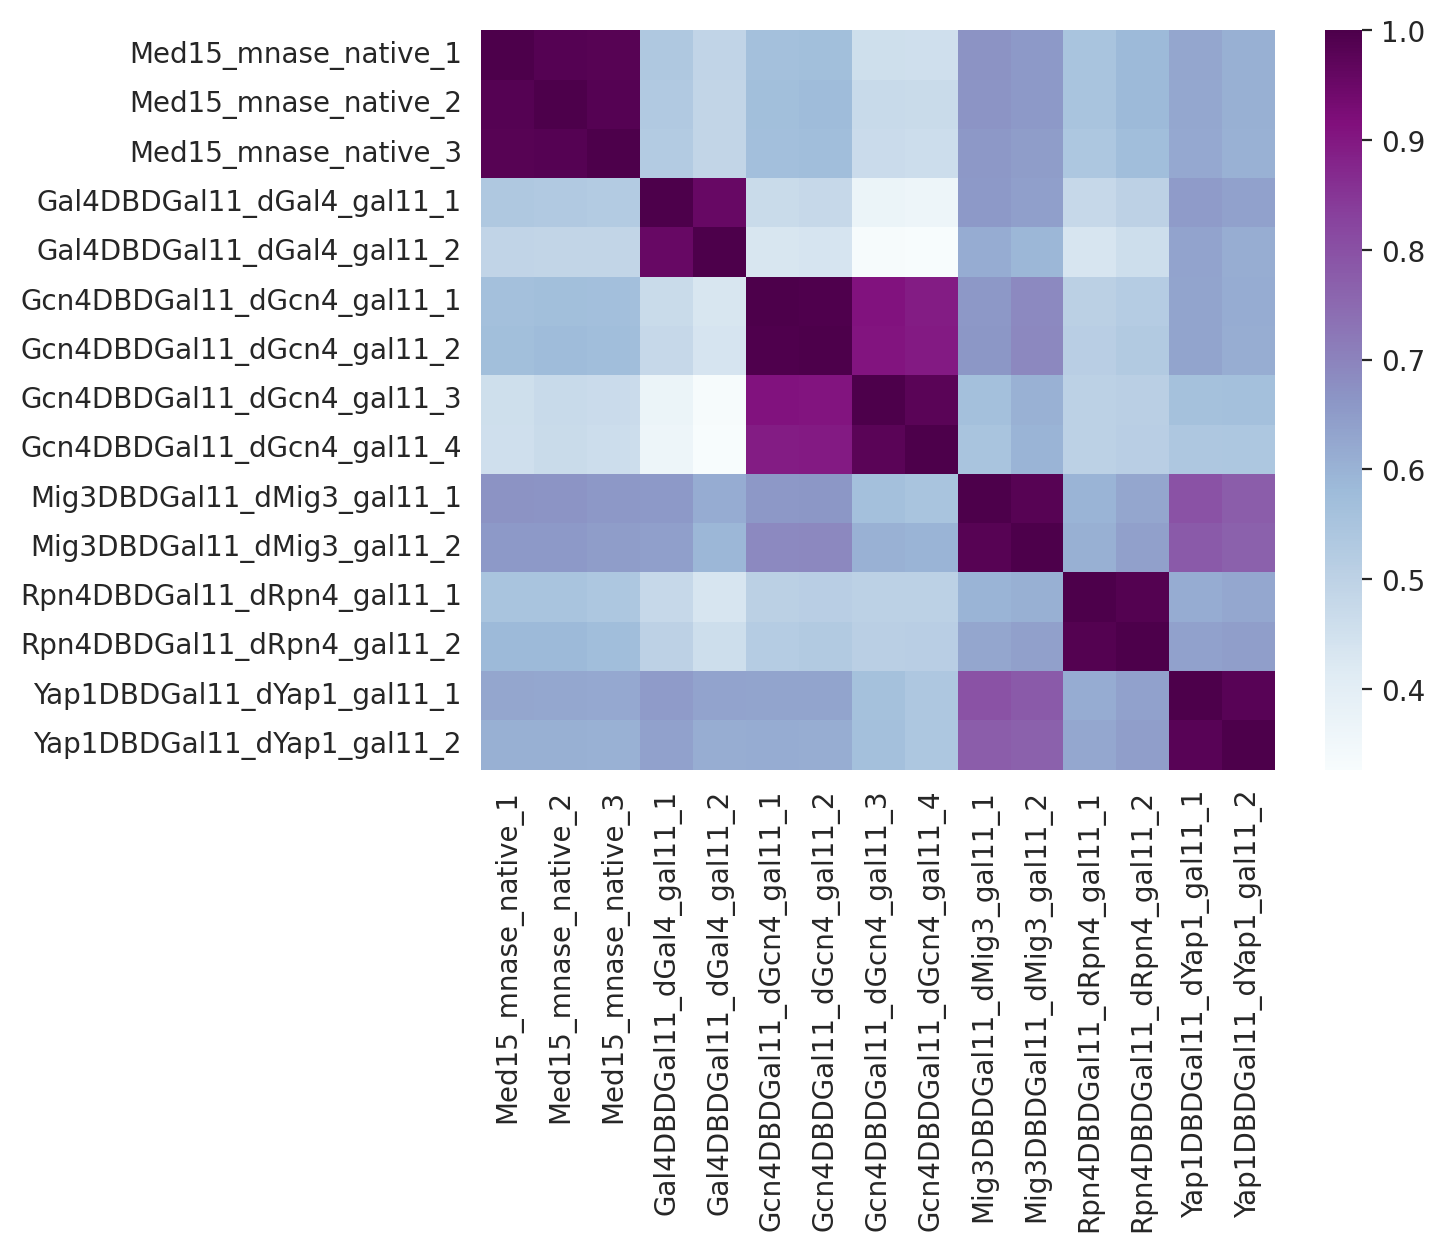

In [13]:
corrmatrepeats = pd.read_csv('data/s14A_Data.csv', index_col=0)
fig, ax = plt.subplots(1)
sns.heatmap(corrmatrepeats.corr(), cmap = 'BuPu',)

fig.savefig('figures/Supp/S14A.pdf')

/tmp/ipykernel_173524/2466826120.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set_xticklabels(axi.get_xticklabels(), size=ts)
/tmp/ipykernel_173524/2466826120.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set_yticklabels(axi.get_yticklabels(), size=ts)


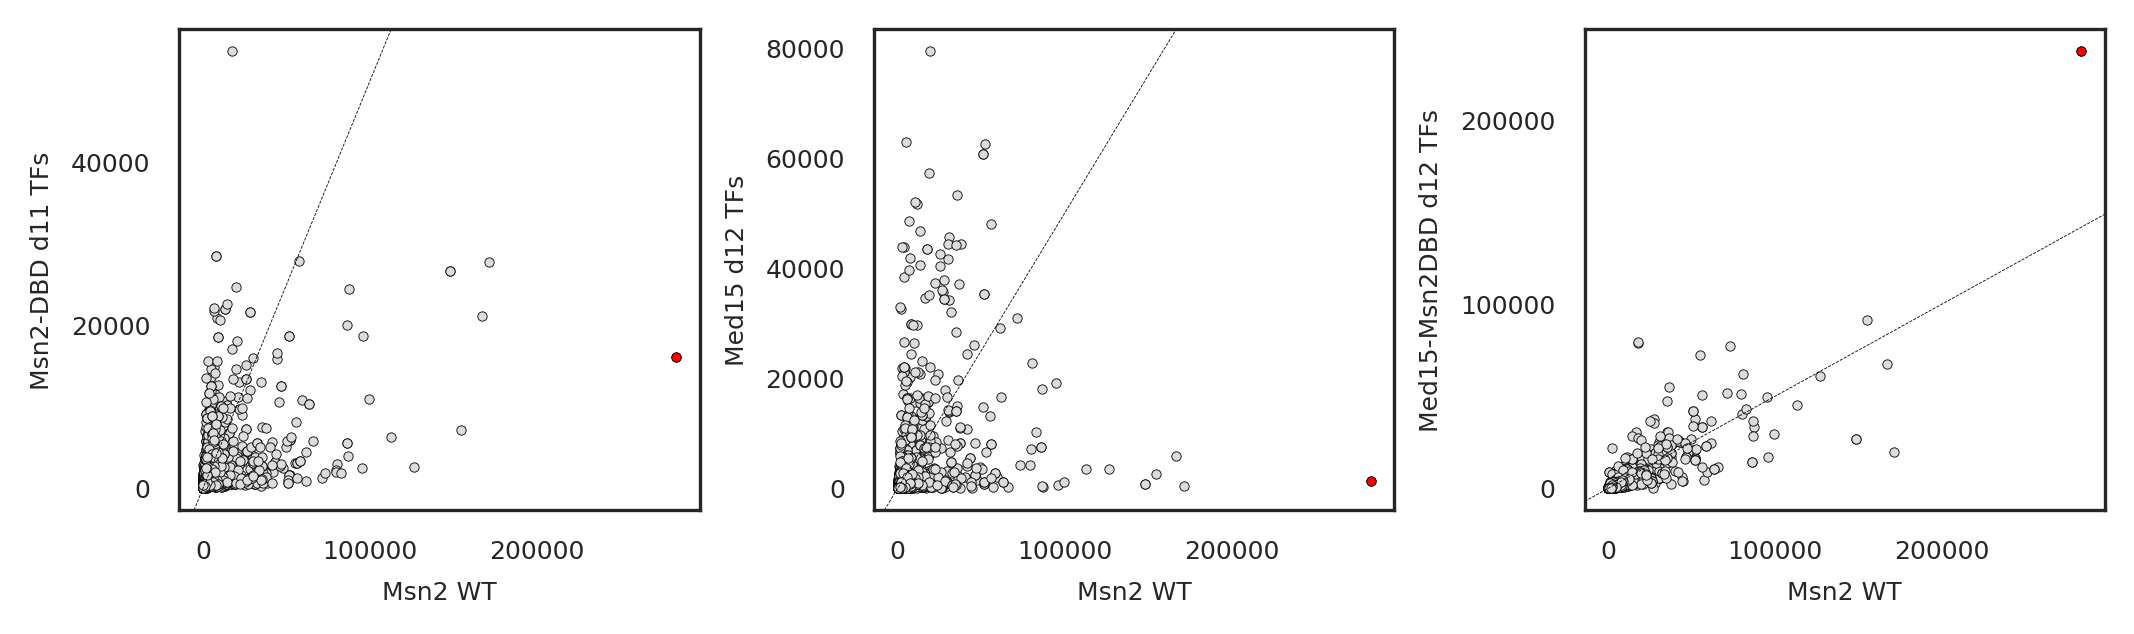

In [14]:
s = 5

fig, ax = plt.subplots(1,3, figsize=(7,2), sharey=False, sharex=True, dpi=150, constrained_layout=True)
ax0, ax1, ax2 = ax

ax0.scatter(fig6df.Msn2_d11, fig6df.Msn2DBDonly_d11, c='gainsboro', s=s, ec='k', lw=.2)
ax1.scatter(fig6df.Msn2_d11, fig6df.Gal11_MNase_d12, c='gainsboro', s=s, ec='k', lw=.2)
ax2.scatter(fig6df.Msn2_d11, fig6df.Med15_Msn2DBD_Mnased11TFs, c='gainsboro', s=s, ec='k', lw=.2)


ax0.scatter(fig6df.Msn2_d11.loc[['HXK1']], fig6df.Msn2DBDonly_d11.loc[['HXK1']], c='red', s=s, ec='k', lw=.2)
ax1.scatter(fig6df.Msn2_d11.loc[['HXK1']], fig6df.Gal11_MNase_d12.loc[['HXK1']], c='red', s=s, ec='k', lw=.2)
ax2.scatter(fig6df.Msn2_d11.loc[['HXK1']], fig6df.Med15_Msn2DBD_Mnased11TFs.loc[['HXK1']], c='red', s=s, ec='k', lw=.2)
ts = 6
for axi in ax:
    axi.axline((0,0), slope=1, c='k', ls='--', lw=.2)
    axi.set_xlabel('Msn2 WT', size=ts)
    axi.set_xticklabels(axi.get_xticklabels(), size=ts)
    axi.set_yticklabels(axi.get_yticklabels(), size=ts)
ax0.set_ylabel('Msn2-DBD d11 TFs', size=ts)
ax1.set_ylabel('Med15 d12 TFs', size=ts)
ax2.set_ylabel('Med15-Msn2DBD d12 TFs', size=ts)
plt.axis('tight')
fig.savefig('figures/Main/fig7/7F.pdf', bbox_inches = 'tight', transparent=True)


In [15]:
df = fig6df.loc[:, ['Msn2_lab_data', 'Msn2DBDonly_d11', 'Gal11_MNase_d12',
       'Med15_Msn2DBD_Mnased11TFs']]
msn2_active = ['CTT1', 'TDA1', 'BAP2', 'GLK1', 'GSY2', 'STF2', 'HSP30', 'HST2',
         'PAL2', 'RGI1', 'ZWF1', 'SPI1', 'RAS2', 'FMP48', 'DOT6', 'TMA10',
         'HSP12', 'OM14', 'UGP1', 'GAC1', 'TSL1', 'MEO1', 'NNR2', 'TPO4',
         'YGP1', 'RTC3', 'COQ21', 'PNC1', 'MSC1', 'MCR1', 'DDR2', 'BDH2',
         'ICY1', 'GID8', 'TPS2', 'GRH1', 'COX26', 'HOR7', 'YDL124W', 'UBX6',
         'HXT7', 'AIM17', 'STP4', 'NCE102', 'PGM2', 'GIS1', 'GPH1', 'GLC3',
         'BMH1', 'YBR085C-A', 'YLR257W', 'GSY1', 'CCW22', 'HXK1', 'PEX2',
         'EMI2', 'TPS1', 'IGD1', 'CIP1']

/home/labs/barkailab/vovam/papers_env/lib/python3.8/site-packages/seaborn/categorical.py:3540: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_173524/2238282685.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/home/labs/barkailab/vovam/papers_env/lib/python3.8/site-packages/seaborn/categorical.py:3540: UserWarning: 11.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


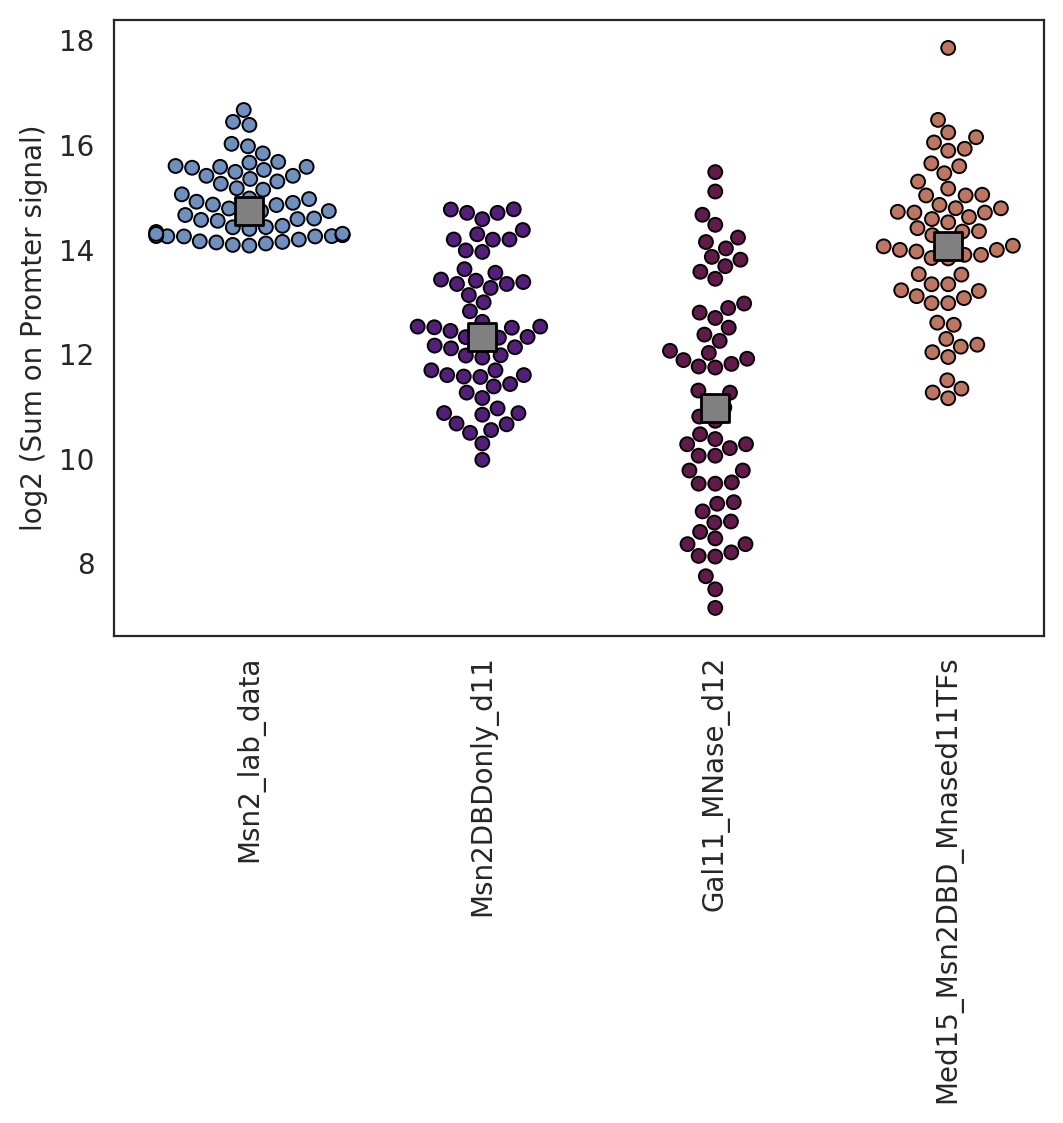

In [16]:
fig, ax = plt.subplots(1, figsize=(6,4))
log2df = np.log2(df)
sns.swarmplot(log2df.loc[msn2_active], palette='twilight', ax=ax, edgecolor='k', linewidth=.7)
ax.scatter(log2df.loc[msn2_active].columns, log2df.loc[msn2_active].median(), zorder=20, s=100, c='gray', ec='k', marker='s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('log2 (Sum on Promter signal)')
fig.savefig('figures/Main/fig7/7H_2.pdf', bbox_inches = 'tight', transparent=True)


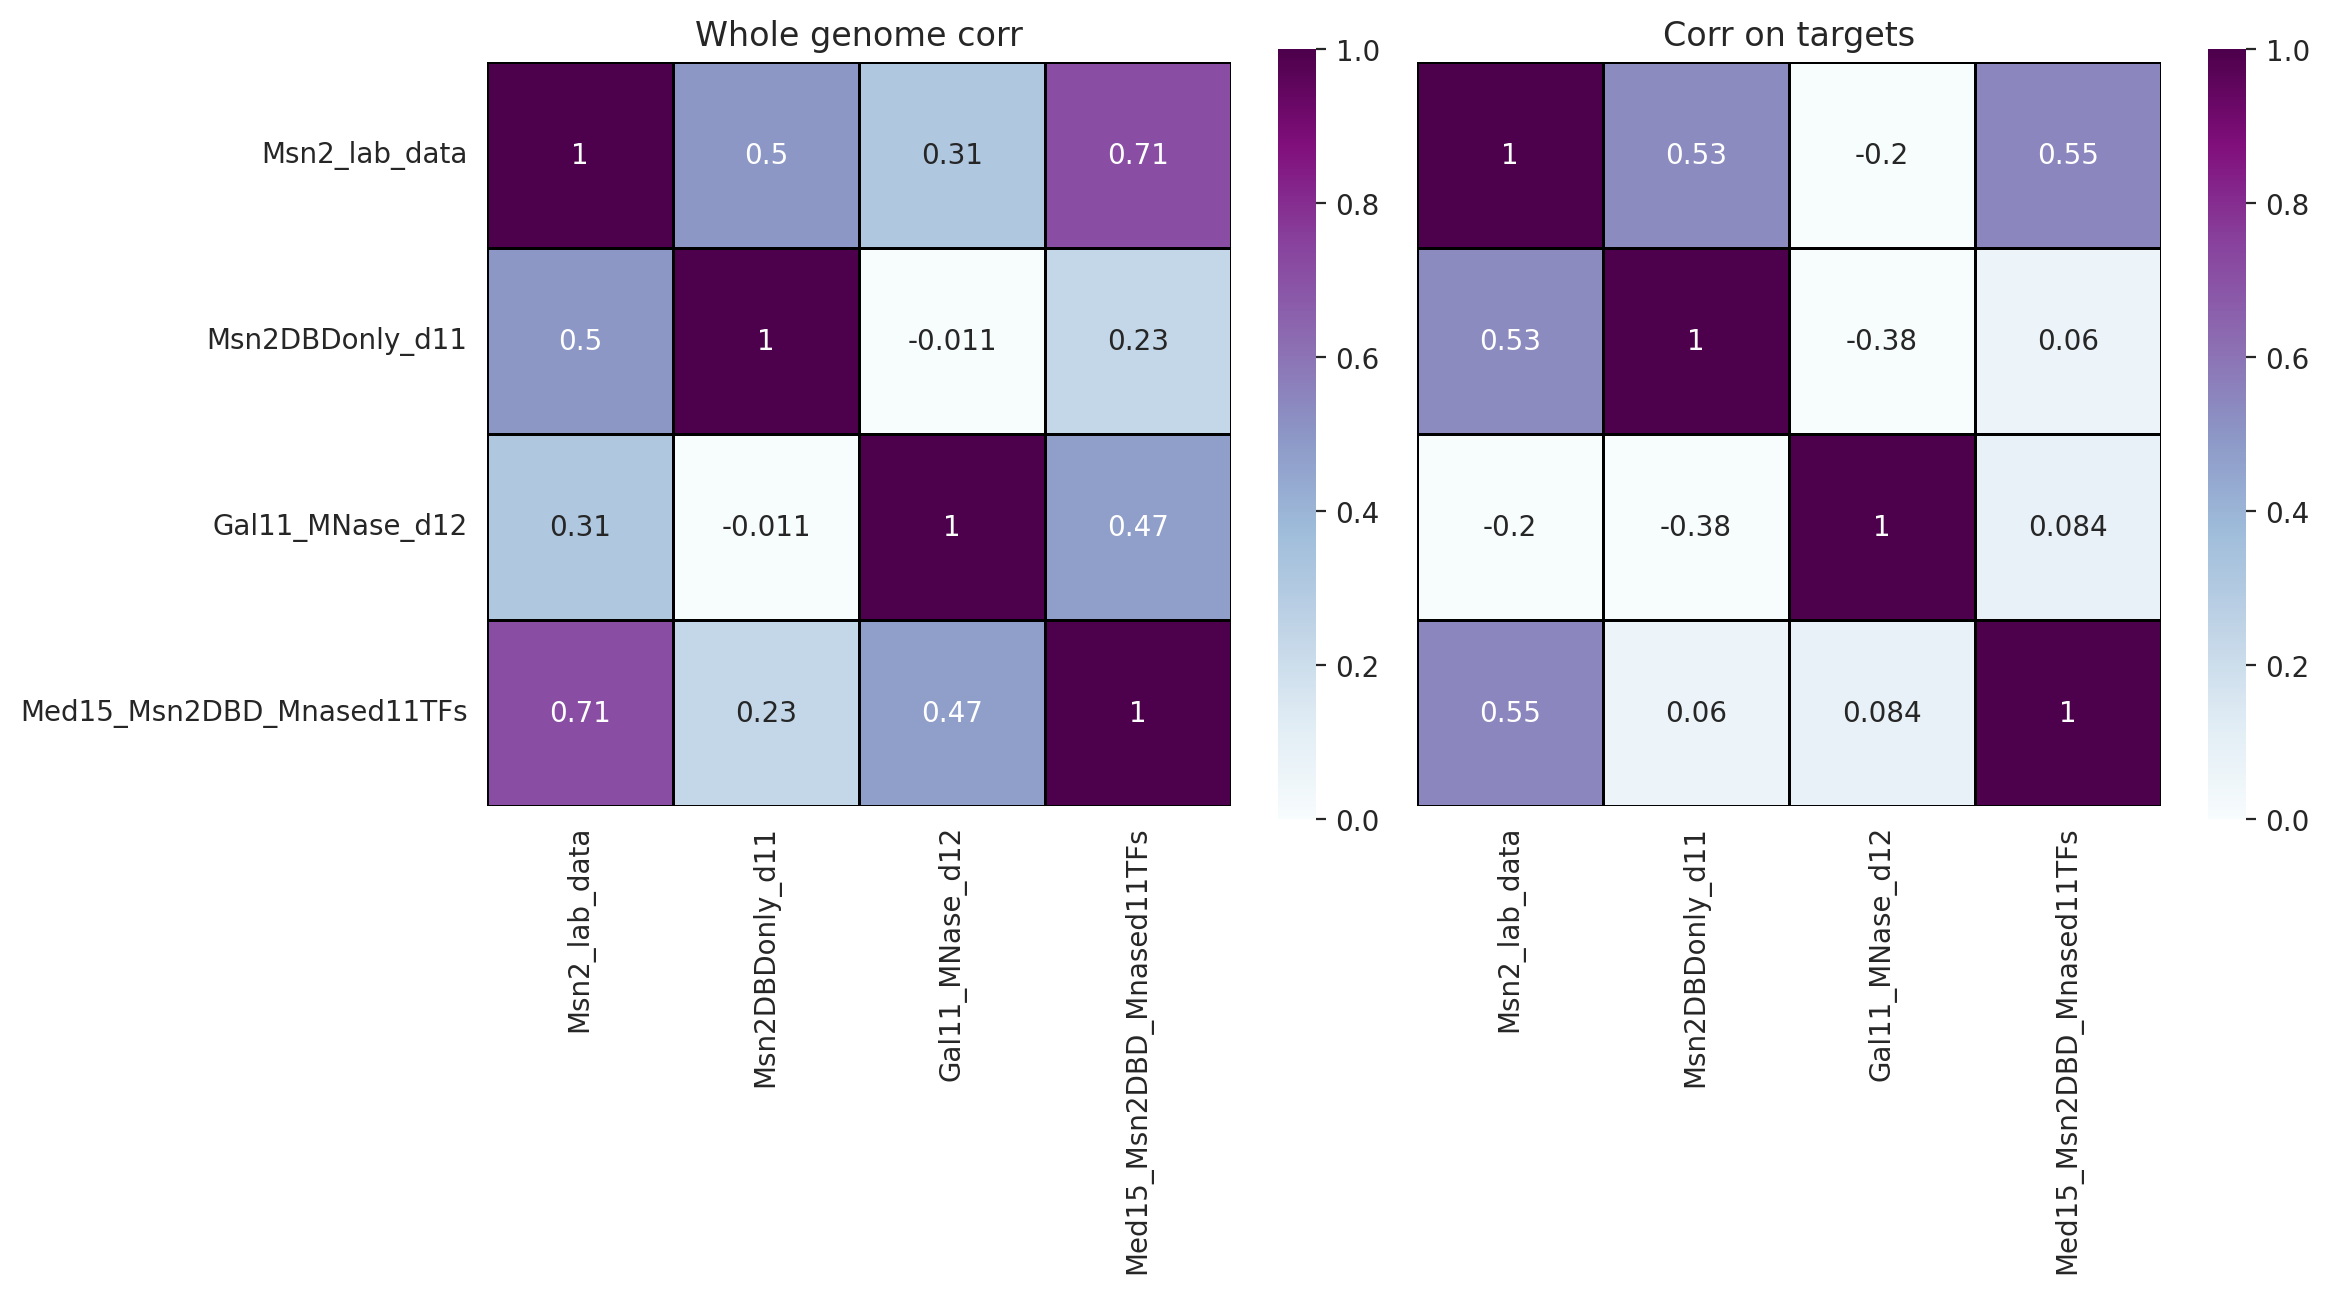

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), constrained_layout=False, sharey=True)
ax0, ax1 = ax
cmap='BuPu'
sns.heatmap(df.corr(), annot=True, ax=ax0, cmap=cmap, square=True, linecolor='k', lw=1, vmin=0)
sns.heatmap(df.loc[msn2_active].corr(), annot=True, ax=ax1, cmap=cmap, square=True, linecolor='k', lw=1, vmin=0)
fig.subplots_adjust(wspace=0)

ax[0].set_title('Whole genome corr')
ax[1].set_title('Corr on targets')
fig.savefig('figures/Main/fig7/7H_1.pdf', bbox_inches = 'tight', transparent=True)


In [18]:
def draw_arrow(ax, coords, hw, hl, wd, ya,s, text):
    start = coords[0]
    stop = coords[1]
    if (start-stop) > 0:
        ax.arrow(start, ya, -(start-stop)+hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    else:
        ax.arrow(start, ya, (stop-start)-hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    ax.text((min(start,stop)+np.abs(stop-start)/4), ya, text, size=s)

def draw_line(ax, coord, c='k', lw=.5, ls='--'):
    ax.axvline(coord, c=c, lw=lw, ls=ls)


In [19]:
import pickle
with open('data/nuc_struct.pkl', 'rb') as f:
    nucchr = pd.DataFrame(pickle.load(f))

In [20]:
colors = ['#160d21',
 '#160d21',
 '#15424e',
 '#15424e',
 '#15424e',
 '#15424e',
 '#1b6145',
 '#1b6145',
 '#387434',
 '#387434',
 '#387434',
 '#387434',
 '#697b30']

titles = ['Msn2 d11', 'Msn2 d11', 'Msn2DBD d11',
       'Msn2DBD d11', 'Msn2DBD d11',
       'Msn2DBD d11', 'Med15 d12', 'Med15 d12',
       'Med15-Msn2DBD d12TFs', 'Med15-Msn2DBD d12TFs',
       'Med15-Msn2DBD d12TFs', 'Med15-Msn2DBD d12TFs', 'Free MNase']

/tmp/ipykernel_173524/1714600235.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axi.set_yticklabels(axi.get_yticklabels(), size=5)


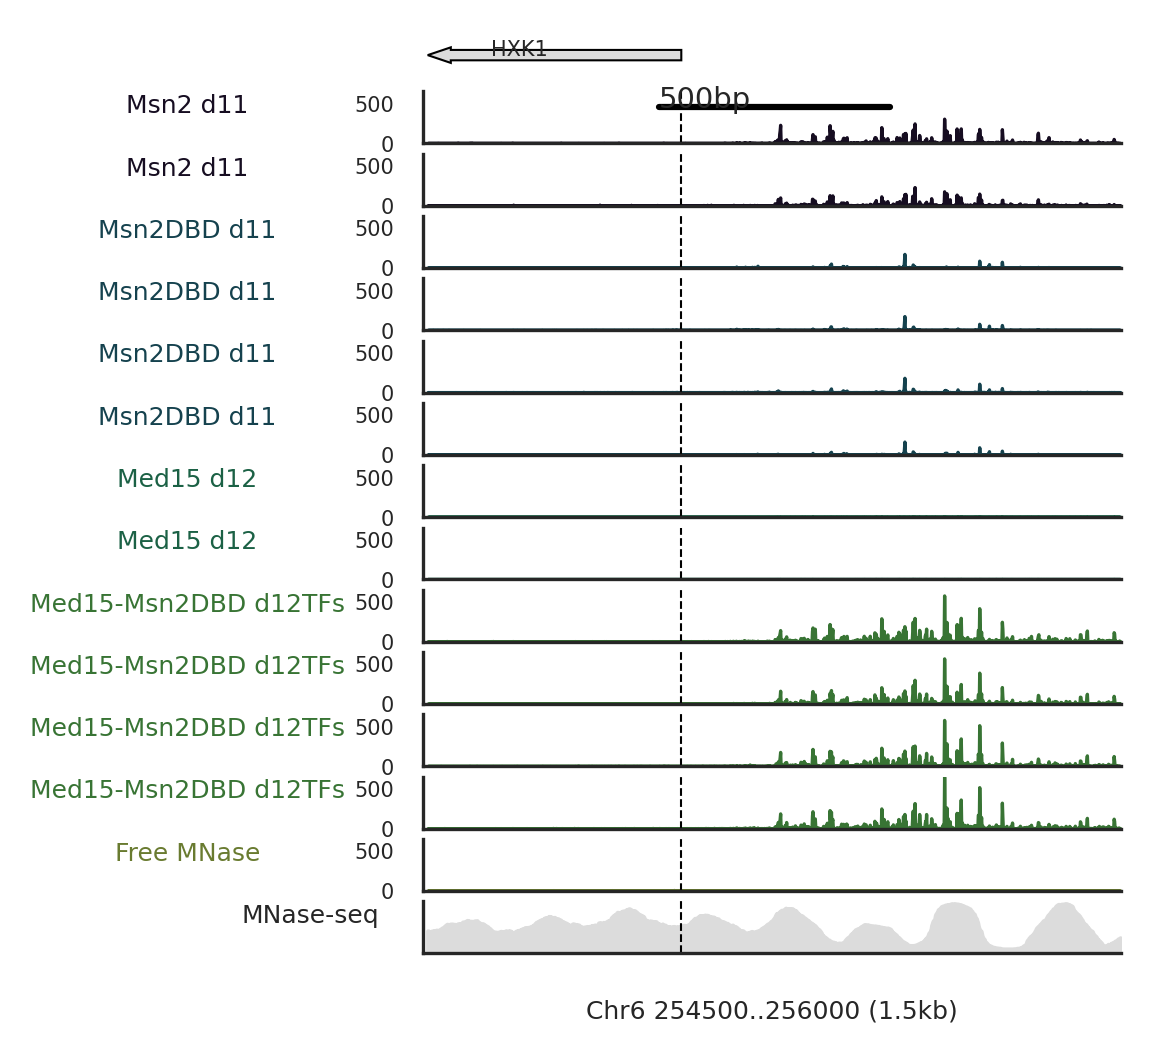

In [21]:
chrom = 6
startchr = 254500
stopchr = 256000

coords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
# tracks = norm_tracks.loc[chrom].apply(lambda x: x[startchr:stopchr])

tracks = pd.read_pickle('data/fig7g.gz')
fig, ax = plt.subplots(tracks.shape[0]+2,1, constrained_layout=False, sharex=True, sharey=False, dpi=150, figsize=(3,4))

for tfi, axi, colori, titlei in zip(tracks.index, ax[1:], colors, titles):
    plot_vec = tracks.loc[tfi]
    axi.fill_between(np.arange(plot_vec.shape[0]), plot_vec,color=colori,lw=.8)
    sns.despine(ax=axi, top=True, right=True)
    axi.set_ylabel(titlei, size=6, rotation=0, labelpad=40)
    axi.yaxis.label.set_color(colori)
    axi.set_xlim([-10,stopchr-startchr])
    axi.set_ylim([-5, max(tracks.apply(lambda x: max(x)))])
    axi.set_yticklabels(axi.get_yticklabels(), size=5)
    


ax[0].set_ylim([0, 100])
hw = 30
hl = 50
wd = 20
ya = 50
ts = 5
for i in range(coords.shape[0]):
    text = coords.index[i]
    draw_arrow(ax[0], coords.values[i], hw, hl, wd, ya, ts, text)
    for axi in ax[1:]:
        draw_line(axi, coords.values[i][0])


ax[0].set_yticklabels('')
sns.despine(ax=ax[0], top=True, right=True, bottom=True, left=True)

ax[-1].fill_between(range(stopchr-startchr), nucchr.loc[chrom].apply(lambda x: x[startchr:stopchr]).values[0], color='gainsboro')
ax[-1].set_yticklabels('')
ax[-1].set_ylabel('MNase-seq', size=6, rotation=0, labelpad=20)
ax[-1].set_xticklabels('')
sns.despine(ax=ax[-1], top=True, right=True, bottom=False)

y = max(tracks.apply(lambda x: max(x))) * 0.7
ax[1].plot([(stopchr-startchr)-1000,(stopchr-startchr)-500],[y,y], c='k')
ax[1].text((stopchr-startchr)-1000, y+2, '500bp', size=7)
ax[-1].set_xticklabels('')
ax[-1].set_xlabel('Chr{} {}..{} ({}kb)'.format(chrom, startchr, stopchr, (stopchr-startchr)/1000), size=6)
fig.savefig('figures/Main/fig7/7G.pdf', bbox_inches = 'tight', transparent=True)


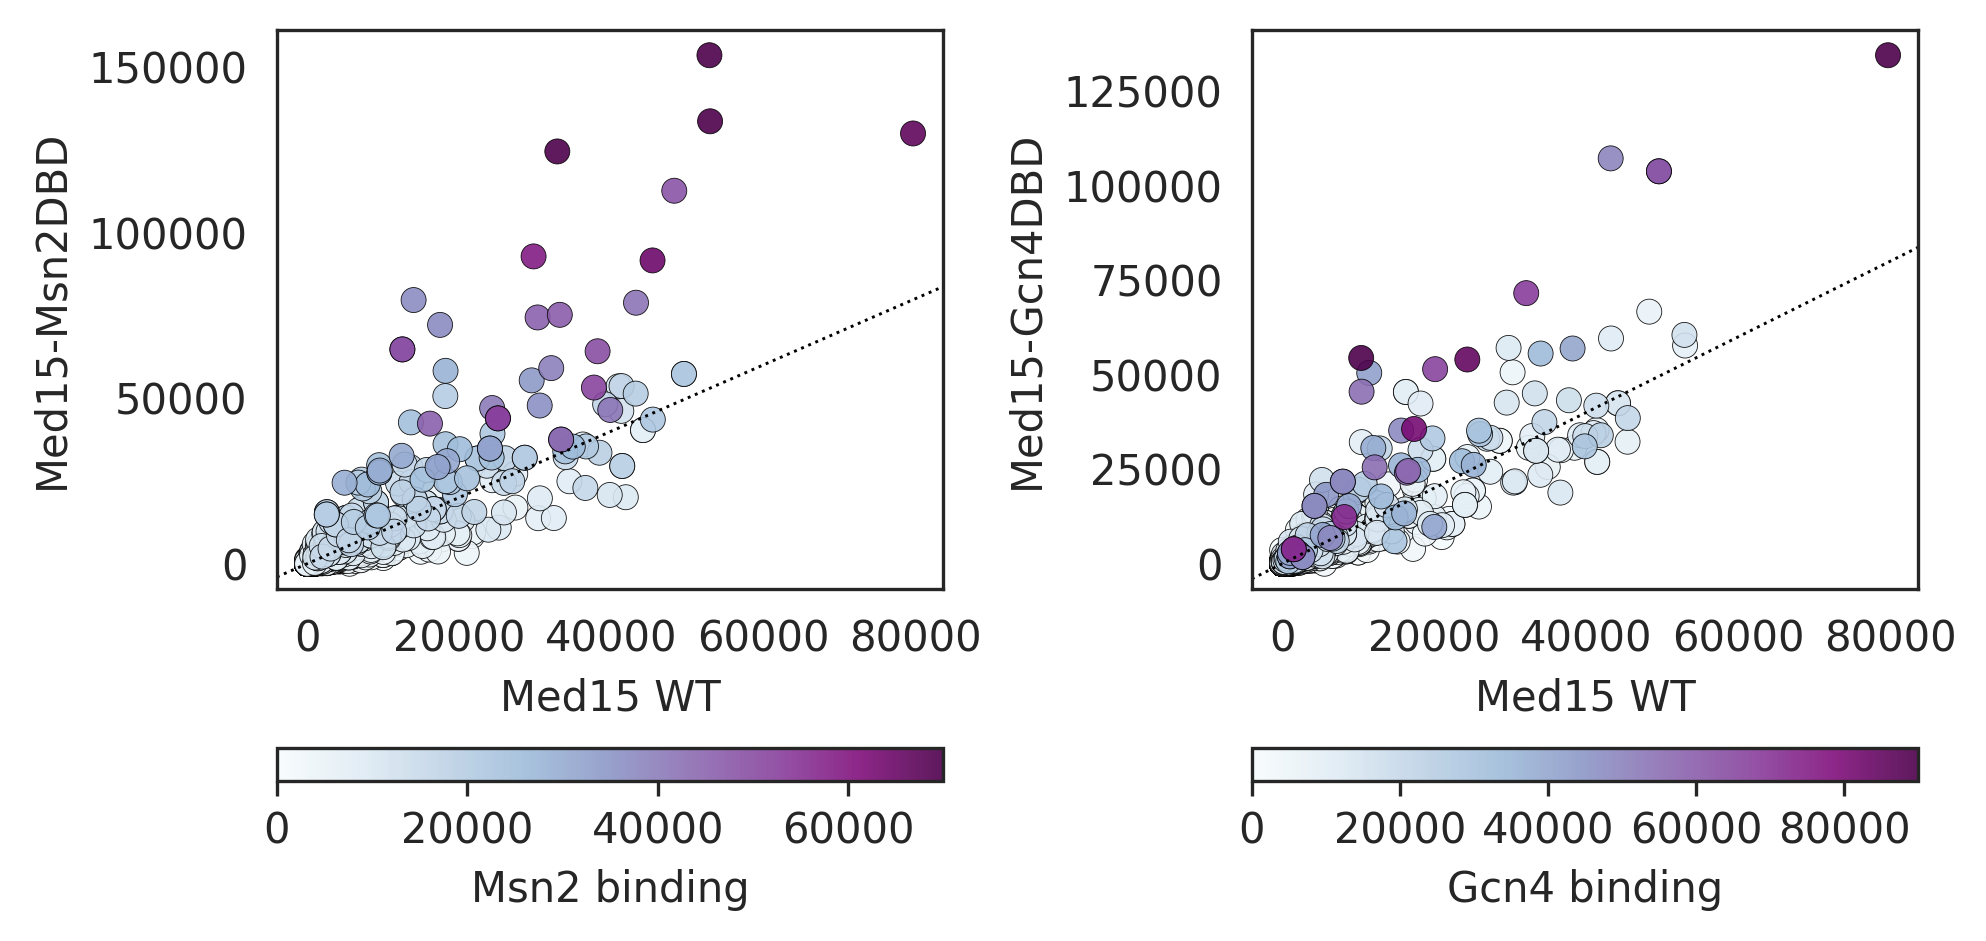

In [22]:
df = fig6df.loc[:, ['Native_med15mnase', 'Med15_Gcn4DBD_Mnase', 'Med15_Msn2DBD_Mnase']]

fig, ax = plt.subplots(1, 2, figsize=(6.5,3), constrained_layout=True, dpi=150)
msn2_ind = fig6df.Msn2_lab_data.sort_values(ascending=True).index
gcn4_ind = fig6df.Gcn4_lown_lab_data.sort_values(ascending=True).index
s = ax[0].scatter(df.Native_med15mnase.loc[msn2_ind], df.Med15_Msn2DBD_Mnase.loc[msn2_ind], c=fig6df.Msn2_lab_data.sort_values(ascending=True), cmap='BuPu', ec='k', lw=0.2, vmax=7e4, alpha=.9)
a = ax[1].scatter(df.Native_med15mnase.loc[gcn4_ind], df.Med15_Gcn4DBD_Mnase.loc[gcn4_ind], c=fig6df.Gcn4_lown_lab_data.sort_values(ascending=True), cmap='BuPu', ec='k', lw=0.2, vmax=9e4, alpha=.9)
fig.colorbar(s, location='bottom', label='Msn2 binding')
fig.colorbar(a, location='bottom', label='Gcn4 binding')

ax[0].set_ylabel('Med15-Msn2DBD')
ax[1].set_ylabel('Med15-Gcn4DBD')
for axi in ax:
    axi.axline((0,0), slope=1,c='k', lw=.7, ls=':')
    axi.set_xlabel('Med15 WT')
fig.savefig('figures/Main/fig7/7B.pdf', bbox_inches = 'tight', transparent=True)


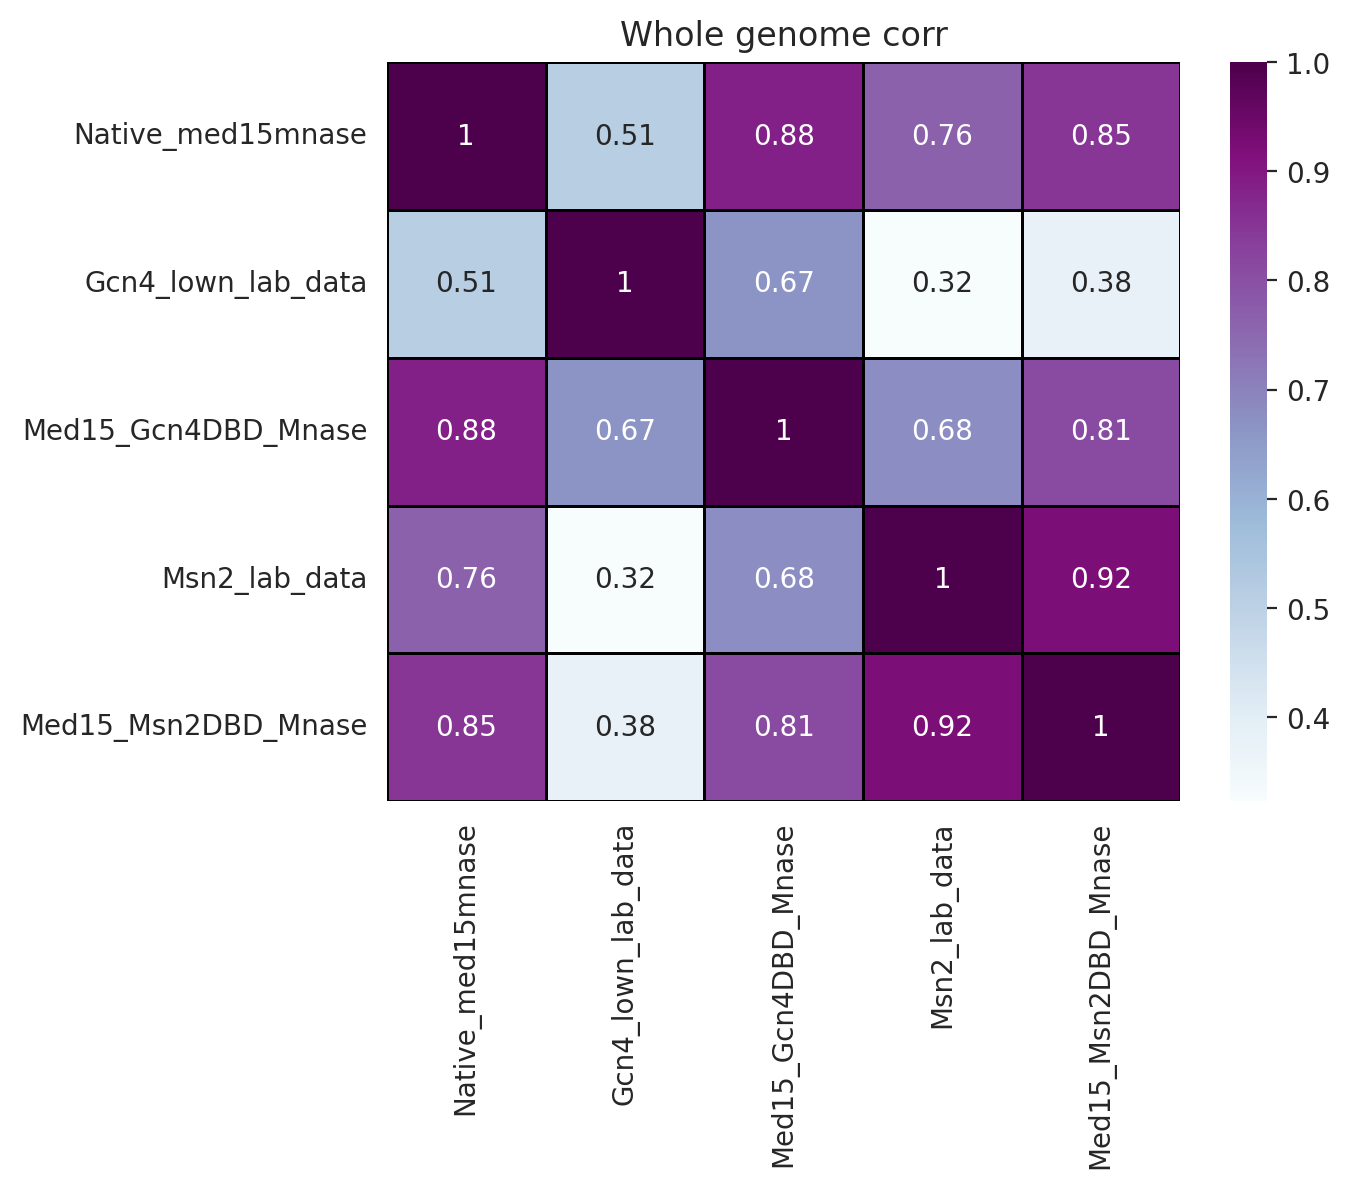

In [23]:
df = fig6df.loc[:, ['Native_med15mnase', 'Gcn4_lown_lab_data', 'Med15_Gcn4DBD_Mnase','Msn2_lab_data',
        'Med15_Msn2DBD_Mnase']]
fig, ax = plt.subplots(1)
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='BuPu', linecolor='k', lw=1)
ax.set_title('Whole genome corr')
fig.savefig('figures/Main/fig7/7C.pdf', bbox_inches = 'tight', transparent=True)


In [24]:
def get_vec(data, vec):
    vec_d = vec.transpose().to_dict()
    res = []
    for key, value in vec_d.items():
        chrom = value['chrom']
        start = value['start']
        stop = value['stop']
        func = lambda x: x.loc[chrom][start:stop]

        res.append(data.apply(func))
    return res

In [25]:
mot_tracks = pd.read_pickle('data/fig7B.gz')

In [26]:
msn2_mot_vec = pd.read_csv('data/motif_hits/motifs_hits_Msn2.csv', index_col=0)
motbpframe = pd.concat([msn2_mot_vec.Chromosome, pd.DataFrame(msn2_mot_vec.motif_middle.apply(lambda x: [x-50, x+50]).to_dict()).transpose()], axis=1)
motbpframe.columns = ['chrom', 'start', 'stop']
vec_d = motbpframe.transpose().to_dict()
res = defaultdict(dict)
for key, value in vec_d.items():
    chrom = value['chrom']
    start = value['start']
    stop = value['stop']
    func = lambda x: x.loc[chrom][start:stop]
    res[key] = (mot_tracks.apply(func))

dat = pd.concat(res, axis=1)
enrich_msn2 = dat.transpose().reset_index().groupby('level_1').mean().drop('level_0', axis=1).transpose()
enrich_msn2.columns = enrich_msn2.columns.str[:-2]
mean_enrich_msn2 = enrich_msn2.transpose().reset_index().groupby('level_1').mean().T


In [27]:
gcn4_mot_vec = pd.read_csv('data/motif_hits/motifs_hits_Gcn4.csv', index_col=0)
motbpframe = pd.concat([gcn4_mot_vec.Chromosome, pd.DataFrame(gcn4_mot_vec.motif_middle.apply(lambda x: [x-50, x+50]).to_dict()).transpose()], axis=1)
motbpframe.columns = ['chrom', 'start', 'stop']

In [28]:
vec_d = motbpframe.transpose().to_dict()
res = defaultdict(dict)
for key, value in vec_d.items():
    chrom = value['chrom']
    start = value['start']
    stop = value['stop']
    func = lambda x: x.loc[chrom][start:stop]
    res[key] = (mot_tracks.apply(func))

dat = pd.concat(res, axis=1)
enrich_gcn4 = dat.transpose().reset_index().groupby('level_1').mean().drop('level_0', axis=1).transpose()
enrich_gcn4.columns = enrich_gcn4.columns.str[:-2]
mean_enrich_gcn4 = enrich_gcn4.transpose().reset_index().groupby('level_1').mean().T


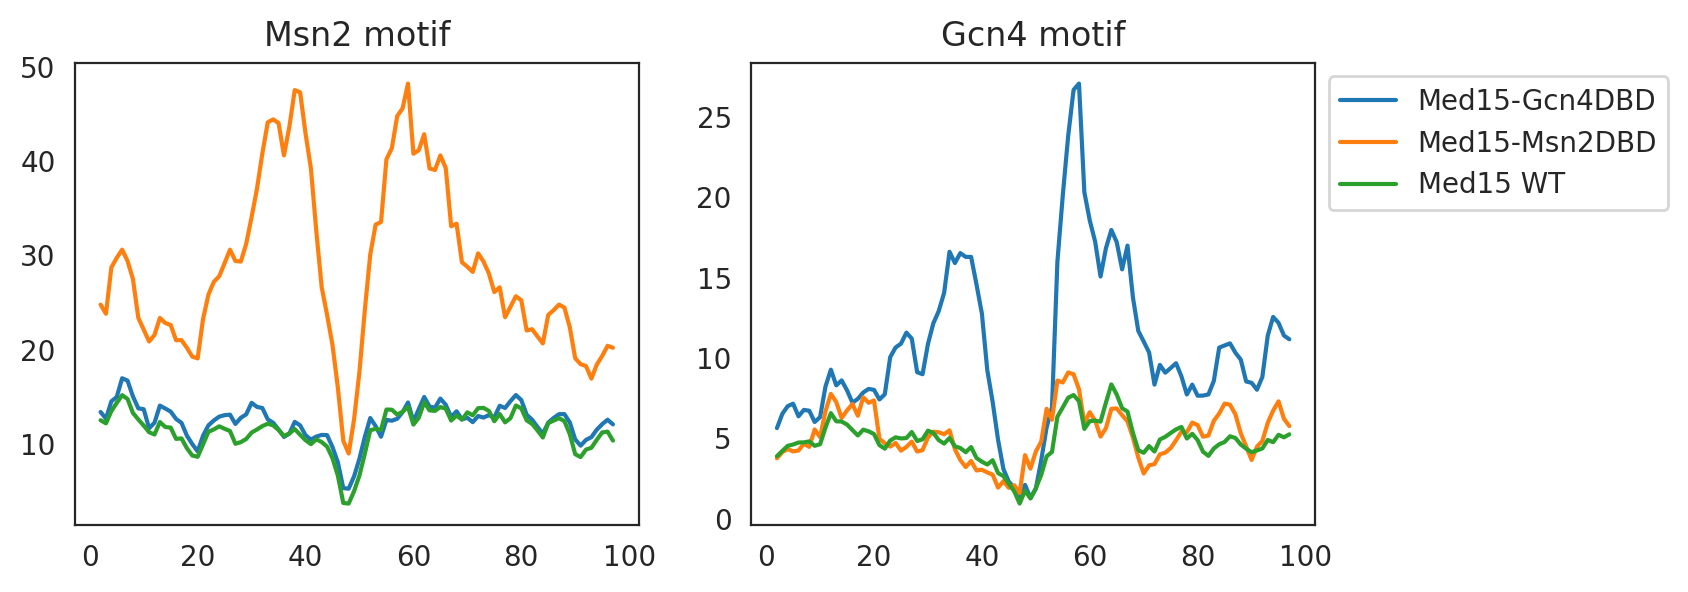

In [29]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
wnd=5
ax[0].plot(mean_enrich_msn2.rolling(window=wnd, center=True).mean())
ax[1].plot(mean_enrich_gcn4.rolling(window=wnd, center=True).mean(), label=['Med15-Gcn4DBD', 'Med15-Msn2DBD', 'Med15 WT'])
ax[0].set_title('Msn2 motif')
ax[1].set_title('Gcn4 motif')
ax[1].legend(bbox_to_anchor=(1,1))
fig.savefig('figures/Main/fig7/7D.pdf', bbox_inches = 'tight', transparent=True)


In [30]:
supp_dat = pd.concat([data_waro.filter(regex='^Msn2').filter(regex='deletions_tef'), fig6df.loc[:, [ 'Gcn4Full_dGcn4_deletions_tef_3_reps_0.98_meancorr',
'Gcn4DBD_Gal4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr',
'Gcn4DBD_Gcn4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr',
 'Med15_Gcn4DBD_Mnase',
 'Med15_Msn2DBD_Mnase',]]], axis=1)


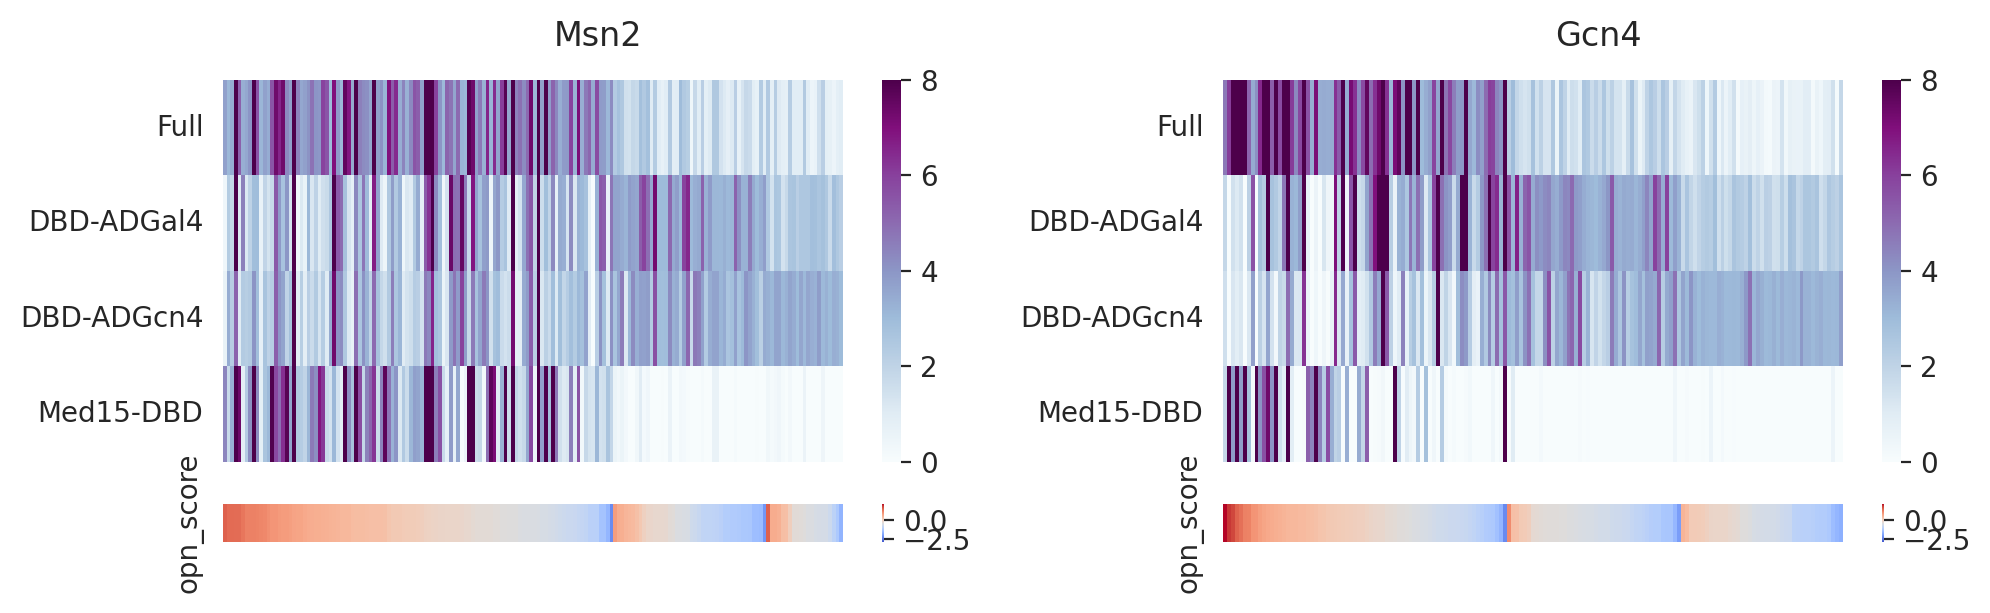

In [31]:
nts = fg.get_targets_df(supp_dat, 3, 'df', opn,)
cdat = gn.get_zscored(supp_dat)

fig = plt.figure(figsize=(10,3))
subf = fig.subfigures(1,2)

for subi, tfi in zip(subf, ["Msn2", 'Gcn4']):
    cts = conc_ts(nts.filter(regex='^'+tfi, axis=0))
    subi.suptitle(tfi)
    ax = subi.subplots(2,1, height_ratios=[10,1], sharex=True)
    sns.heatmap(cdat.filter(regex='^{}|Med15_{}'.format(tfi, tfi)).loc[cts].T, ax=ax[0], cmap='BuPu', vmin=0, vmax=8)
    
    sns.heatmap(pd.DataFrame(opn.loc[cts, 'opn_score']).T, cmap='coolwarm',
                center=opn.mean().values, vmin=opn.min().values, vmax=opn.max().values)
    
    ax[0].set_yticklabels(['Full', 'DBD-ADGal4', 'DBD-ADGcn4', 'Med15-DBD'])
    
    ax[1].set_xticklabels('')
fig.savefig('figures/Supp/S14C.pdf')